In [1]:
import sys
from os import path
import warnings
import logging

logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

SCRIPT_DIR = path.dirname(path.abspath('__file__'))
sys.path.append(path.dirname(SCRIPT_DIR))
sys.dont_write_bytecode = True

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta

from darts.metrics import mape, rmse, mse
from darts.models.forecasting.baselines import NaiveSeasonal, NaiveDrift
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
from darts.models.forecasting.fft import FFT
from darts.models.forecasting.prophet_model import Prophet
from darts.models.forecasting.tbats_model import TBATS
from darts.models.forecasting.theta import Theta
from darts.models.forecasting.xgboost import XGBModel
from darts.timeseries import TimeSeries
from darts.utils.statistics import check_seasonality

from typing import Any, Tuple, Union, Literal, Callable

from library.datasets import get_dataframe_summarized, standarize, StandarizeMethod
from library.depresjon import get_measured_days, read_activity_dataset, read_scores_dataset
from library.forecasting import pick_best_forecast_model_for_ts, split_time_series

from sklearn.model_selection import ParameterGrid
from sktime.utils.plotting import plot_series

%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
def transform_dataset(
    df: pd.DataFrame,
    frequency: str = '1T',
    summarize_method: str = 'sum',
    standarize_method: int = StandarizeMethod.DEFAULT,
    remove_outliers: bool = False
) -> pd.DataFrame:
    df_grouped = get_dataframe_summarized(df, frequency, summarize_method)
    df_grouped = df_grouped.rename(columns={'index': 'timestamp'})
    df_grouped['activity'] = standarize(
        df_grouped.activity.to_numpy(),
        method = standarize_method,
        remove_outliers = remove_outliers
    )
    return df_grouped.set_index('timestamp')

In [4]:
pd.options.display.float_format = '{:.4f}'.format
plt.rcParams['figure.figsize'] = [20, 6]
plt.style.use('seaborn-v0_8')
seed = 123

random.seed(seed)
np.random.seed(seed)

DATASETS_PATH = path.realpath(path.join(SCRIPT_DIR, '..', '..', 'dataset'))

In [5]:
# scores dataset
df_scores = read_scores_dataset(f'{DATASETS_PATH}/original/scores.csv')
df_scores.head()

days  gender    age  afftype  melanch  inpatient    edu  \
number                                                                 
condition_1    11       2  35-39   2.0000   2.0000     2.0000   6-10   
condition_2    18       2  40-44   1.0000   2.0000     2.0000   6-10   
condition_3    13       1  45-49   2.0000   2.0000     2.0000   6-10   
condition_4    13       2  25-29   2.0000   2.0000     2.0000  11-15   
condition_5    13       2  50-54   2.0000   2.0000     2.0000  11-15   

             marriage   work  madrs1  madrs2  
number                                        
condition_1    1.0000 2.0000 19.0000 19.0000  
condition_2    2.0000 2.0000 24.0000 11.0000  
condition_3    2.0000 2.0000 24.0000 25.0000  
condition_4    1.0000 1.0000 20.0000 16.0000  
condition_5    2.0000 2.0000 26.0000 26.0000

In [6]:
hourly_activity_datasets = {}
for file, row in df_scores.iterrows():
    folder = file.split('_')[0]
    days = get_measured_days(df_scores, file)
    df = read_activity_dataset(f'{DATASETS_PATH}/original/{folder}/{file}.csv', days)
    
    hourly_activity_datasets[file] = {
        'mean': transform_dataset(
            df,
            frequency = '1H',
            summarize_method = 'mean',
            standarize_method = StandarizeMethod.ROBUST,
            remove_outliers = False
        ),
        'median': transform_dataset(
            df,
            frequency = '1H',
            summarize_method = 'median',
            standarize_method = StandarizeMethod.DEFAULT,
            remove_outliers = False
        )
    }
hourly_activity_datasets['condition_1']['mean'].head()

activity
timestamp                    
2003-05-08 00:00:00   -0.6786
2003-05-08 01:00:00   -0.7073
2003-05-08 02:00:00   -0.6854
2003-05-08 03:00:00   -0.7077
2003-05-08 04:00:00   -0.6477

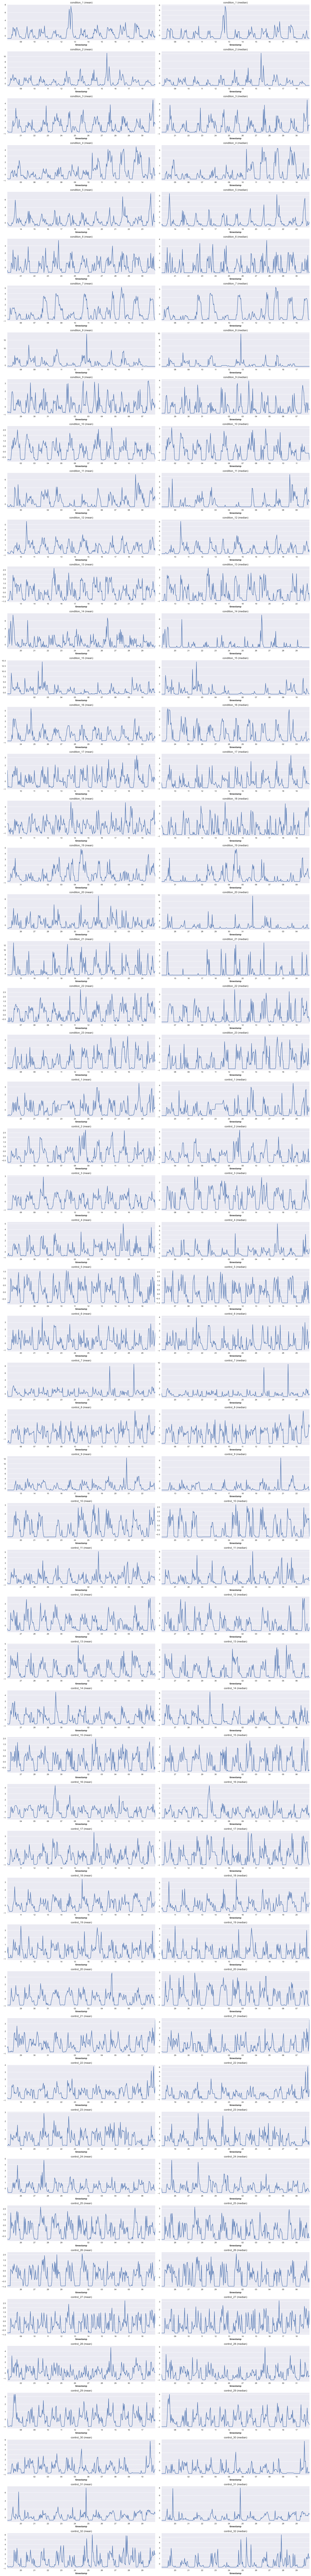

In [7]:
fig, axes = plt.subplots(
    nrows = len(hourly_activity_datasets),
    ncols = 2,
    figsize = (20, len(hourly_activity_datasets) * 3)
)

index = 0
for file, dfs in hourly_activity_datasets.items():
    dfs['mean'].activity.plot(ax = axes[index, 0], title=f'{file} (mean)', xticks=[])
    dfs['median'].activity.plot(ax = axes[index, 1], title=f'{file} (median)', xticks=[])
    index += 1
    
fig.tight_layout()
plt.show()

In [8]:
df_results = pd.DataFrame(columns=[
    'number',
    'seasonality_mean',
    'seasonality_period_mean',
    'seasonality_median',
    'seasonality_period_median',
])
for file, dfs in hourly_activity_datasets.items():
    df_mean = TimeSeries.from_series(dfs['mean'].activity)
    df_median = TimeSeries.from_series(dfs['median'].activity)
    
    seasonality_mean, seasonality_period_mean = check_seasonality(df_mean)
    seasonality_median, seasonality_period_median = check_seasonality(df_median)
    
    df_results.loc[len(df_results)] = {
        'number': file,
        'seasonality_mean': seasonality_mean,
        'seasonality_period_mean': seasonality_period_mean,
        'seasonality_median': seasonality_median,
        'seasonality_period_median': seasonality_period_median
    }

df_results.set_index('number').T

number                    condition_1 condition_2 condition_3 condition_4  \
seasonality_mean                False        True        True       False   
seasonality_period_mean             0           4          23           0   
seasonality_median              False        True        True        True   
seasonality_period_median           0           4          21          23   

number                    condition_5 condition_6 condition_7 condition_8  \
seasonality_mean                False       False       False        True   
seasonality_period_mean             0           0           0          22   
seasonality_median              False        True       False        True   
seasonality_period_median           0           5           0          22   

number                    condition_9 condition_10 condition_11 condition_12  \
seasonality_mean                 True         True        False        False   
seasonality_period_mean            21           23            0            0   
seasonality_median               True         True         True        False   
seasonality_period_median          21           23           22            0   

number                    condition_13 condition_14 condition_15 condition_16  \
seasonality_mean                 False         True         True        False   
seasonality_period_mean              0           23            7            0   
seasonality_median               False         True         True         True   
seasonality_period_median            0            8            3           23   

number                    condition_17 condition_18 condition_19 condition_20  \
seasonality_mean                 False        False        False         True   
seasonality_period_mean              0            0            0            3   
seasonality_median                True        False         True         True   
seasonality_period_median           22            0           17            3   

number                    condition_21 condition_22 condition_23 control_1  \
seasonality_mean                  True         True         True      True   
seasonality_period_mean             18           19           22        23   
seasonality_median                True         True         True      True   
seasonality_period_median            4           19           22        22   

number                    control_2 control_3 control_4 control_5 control_6  \
seasonality_mean              False     False      True     False      True   
seasonality_period_mean           0         0         4         0        18   
seasonality_median            False     False      True     False      True   
seasonality_period_median         0         0         4         0        18   

number                    control_7 control_8 control_9 control_10 control_11  \
seasonality_mean               True     False      True      False       True   
seasonality_period_mean          20         0        21          0         20   
seasonality_median             True     False      True      False       True   
seasonality_period_median        20         0        21          0         20   

number                    control_12 control_13 control_14 control_15  \
seasonality_mean               False      False       True      False   
seasonality_period_mean            0          0         23          0   
seasonality_median             False      False       True      False   
seasonality_period_median          0          0         23          0   

number                    control_16 control_17 control_18 control_19  \
seasonality_mean               False      False       True      False   
seasonality_period_mean            0          0         23          0   
seasonality_median             False       True      False      False   
seasonality_period_median          0         21          0          0   

number                    control_20 control_21 control_22 control_23  \
seasonality_mean 

In [9]:
def get_epsilon():
    return sys.float_info.epsilon

In [10]:
available_models = [
    NaiveSeasonal(K = 168),
    XGBModel(lags = 24, random_state = seed),
    ExponentialSmoothing(random_state = seed),
    Prophet(floor = 0),
    FFT(nr_freqs_to_keep = 24)
]

df_models_scores = pd.DataFrame(columns=[
    'number',
    'best_model_mean',
    'score_best_model_mean',
    'best_model_median',
    'score_best_model_median',
])

fig, axes = plt.subplots(
    nrows = len(hourly_activity_datasets),
    ncols = 2,
    figsize = (20, len(hourly_activity_datasets) * 3)
)

index = 0
for file, dfs in hourly_activity_datasets.items():
    df_mean = TimeSeries.from_series(dfs['mean'].activity + get_epsilon())
    df_median = TimeSeries.from_series(dfs['median'].activity + get_epsilon())

    best_model_mean, score_best_model_mean = pick_best_forecast_model_for_ts(
        models = available_models,
        data = df_mean,
        test_days = 3,
        random_state = seed,
        # metric = 'RMSE'
    )

    best_model_median, score_best_model_median = pick_best_forecast_model_for_ts(
        models = available_models,
        data = df_median,
        test_days = 3,
        random_state = seed,
        # metric = 'RMSE'
    )

    df_models_scores.loc[len(df_models_scores)] = {
        'number': file,
        'best_model_mean': best_model_mean.__class__.__name__,
        'score_best_model_mean': score_best_model_mean,
        'best_model_median': best_model_median.__class__.__name__,
        'score_best_model_median': score_best_model_median,
    }

    train_mean, test_mean = split_time_series(df_mean, 3)
    best_model_mean.fit(train_mean)
    
    train_median, test_median = split_time_series(df_median, 3)
    best_model_median.fit(train_median)

    # plots mean
    ax0 = axes[index, 0]
    train_mean.plot(label='train', ax=ax0, xticks=[])
    test_mean.plot(label='true', ax=ax0, xticks=[])
    best_model_mean.predict(len(test_mean)).plot(label='prediction', ax=ax0, xticks=[])
    ax0.set_title('{} - {}'.format(file, best_model_mean.__class__.__name__))

    # plots median
    ax1 = axes[index, 1]
    train_median.plot(label='train', ax=ax1, xticks=[])
    test_median.plot(label='true', ax=ax1, xticks=[])
    best_model_median.predict(len(test_median)).plot(label='prediction', ax=ax1, xticks=[])
    ax1.set_title('{} - {}'.format(file, best_model_median.__class__.__name__))

    index += 1

fig.tight_layout()
plt.show()

In [ ]:
pd.set_option('max_colwidth', 300)
df_models_scores